In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [84]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

In [85]:
df = pd.read_csv('datasets/combined_cleaned.csv')

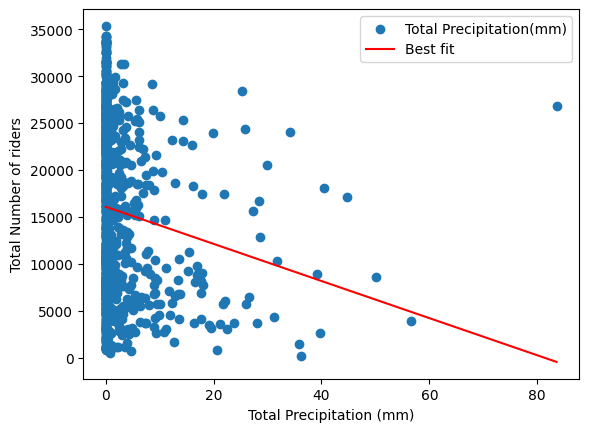

In [86]:
# Total Precip vs riders with line of best fit
x = df['Total Precip (mm)']
y = df['total_riders']
plt.scatter(x, y, label='Total Precipitation(mm)')
coef = np.polyfit(x, y, 1)
line = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, line(xs), color='red', label='Best fit')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Total Number of riders')
plt.legend()
plt.show()


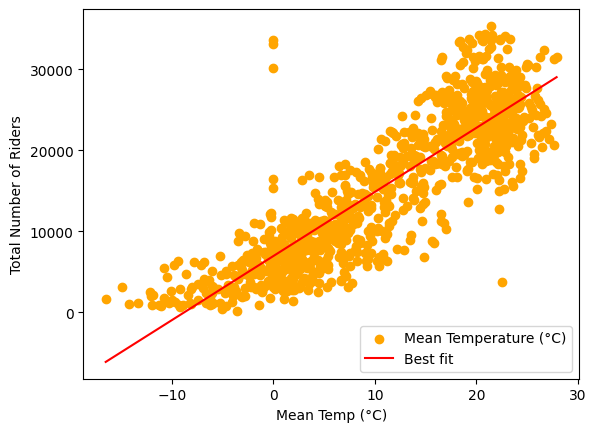

In [87]:
# Mean Temp vs riders with line of best fit
x = df['Mean Temp (°C)']
y = df['total_riders']
plt.scatter(x, y, label='Mean Temperature (°C)', color='orange')
coef = np.polyfit(x, y, 1)
line = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, line(xs), color='red', label='Best fit')
plt.xlabel('Mean Temp (°C)')
plt.ylabel('Total Number of Riders')
plt.legend()
plt.show()


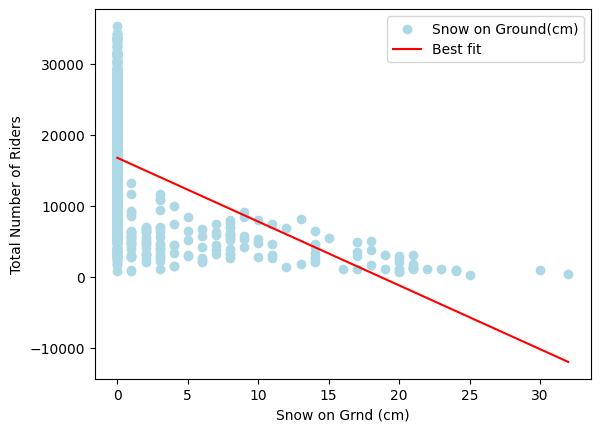

In [88]:
# Snow on ground vs riders with line of best fit
x = df['Snow on Grnd (cm)']
y = df['total_riders']
plt.scatter(x, y, label='Snow on Ground(cm)', color='lightblue')
coef = np.polyfit(x, y, 1)
line = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, line(xs), color='red', label='Best fit')
plt.xlabel('Snow on Grnd (cm)')
plt.ylabel('Total Number of Riders')
plt.legend()
plt.show()


In [89]:
# drop index column and make sure 'date' column is parsed as a pandas datetime object
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df['date'] = pd.to_datetime(df['date'])
df

,date,total_riders,Mean Temp (°C),Snow on Grnd (cm),Total Precip (mm),month,day_of_week,is_weekend,rain_flag,snow_flag,heat_flag,freeze_flag
0,2022-01-01,2851,1.5,0.0,2.4,1,5,1,1,0,0,0
1,2022-01-02,1135,-6.3,3.0,2.0,1,6,1,1,1,0,1
2,2022-01-03,2157,-8.4,3.0,0.0,1,0,0,0,1,0,1
3,2022-01-04,3371,-1.2,3.0,0.0,1,1,0,0,1,0,1
4,2022-01-05,2870,0.2,3.0,0.3,1,2,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999,2024-09-26,34299,20.8,0.0,0.0,9,3,0,0,0,0,0
1000,2024-09-27,32797,18.7,0.0,0.0,9,4,0,0,0,0,0
1001,2024-09-28,27871,20.5,0.0,0.1,9,5,1,1,0,0,0
1002,2024-09-29,28001,20.1,0.0,0.0,9,6,1,0,0,0,0


In [ ]:
# Preparing dataframe going to be inputted into the MLP
feature_cols = [
    'Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
    'month', 'day_of_week', 'is_weekend',
    'rain_flag', 'snow_flag', 'heat_flag', 'freeze_flag'
]

df_model = df[['total_riders', *feature_cols]].copy()

In [91]:
# Handle missing values (simple fill)
df_model = df_model.fillna(0)

In [92]:
# Split into X (features) and y (target)
X = df_model[feature_cols].values.astype('float32')
y = df_model[['total_riders']].values.astype('float32')

In [93]:
# Convert to tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

full_dataset = TensorDataset(X_tensor, y_tensor)

# Train/test split (80/20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [94]:
# Defining neural network
class RidershipNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = RidershipNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model with error logs
epochs = 200
history = {"train_loss": [], "test_loss": []}

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * len(batch_X)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            pred = model(batch_X)
            batch_loss = loss_fn(pred, batch_y)
            running_test_loss += batch_loss.item() * len(batch_X)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)

    history["train_loss"].append(epoch_train_loss)
    history["test_loss"].append(epoch_test_loss)

    print(f"Epoch {epoch + 1}/{epochs} - train MSE: {epoch_train_loss:.4f} | test MSE: {epoch_test_loss:.4f}")

Epoch 1/200 - train MSE: 316563099.6961 | test MSE: 350736479.6816
Epoch 2/200 - train MSE: 316544397.1308 | test MSE: 350675489.7512
Epoch 3/200 - train MSE: 316442589.5691 | test MSE: 350380786.1493
Epoch 4/200 - train MSE: 316045833.7634 | test MSE: 349517218.0697
Epoch 5/200 - train MSE: 314953214.8045 | test MSE: 347461930.3483
Epoch 6/200 - train MSE: 312600190.2864 | test MSE: 344270239.0448
Epoch 7/200 - train MSE: 308242505.6837 | test MSE: 338362953.2338
Epoch 8/200 - train MSE: 301287717.9776 | test MSE: 328901548.2587
Epoch 9/200 - train MSE: 290691775.5616 | test MSE: 313467952.8756
Epoch 10/200 - train MSE: 275117497.9626 | test MSE: 296450130.6269
Epoch 11/200 - train MSE: 255132083.6463 | test MSE: 270516457.7114
Epoch 12/200 - train MSE: 230605592.2291 | test MSE: 244005056.3184
Epoch 13/200 - train MSE: 200445109.5367 | test MSE: 207117001.3930
Epoch 14/200 - train MSE: 168975759.6812 | test MSE: 180629387.9403
Epoch 15/200 - train MSE: 136702295.9502 | test MSE: 1387

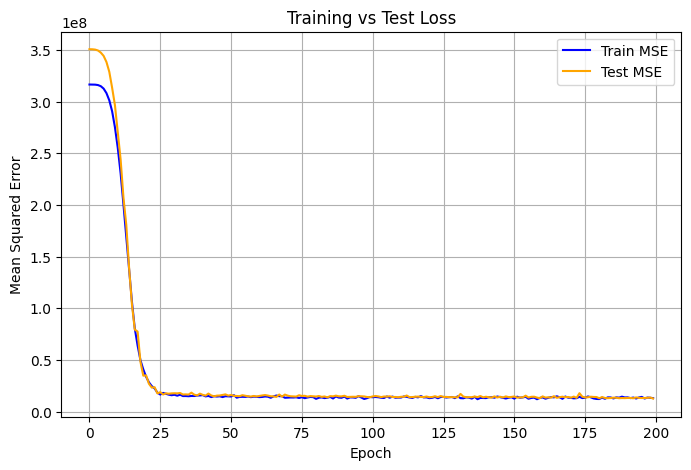

In [97]:
# Plot train vs test loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train MSE', color='blue')
plt.plot(history['test_loss'], label='Test MSE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid()
plt.show()

In [98]:
model.eval()

RidershipNN(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=32, out_features=16, bias=True)
    (12): ReLU()
    (13): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [99]:
# Example Prediction
example_date = pd.to_datetime('2023-07-15')  # Saturday
mean_temp = 25.0
precip = 5.0
snow = 0.0

month = example_date.month
day_of_week = example_date.dayofweek
is_weekend = int(day_of_week >= 5)

rain_flag = int(precip > 0)
snow_flag = int(snow > 0)
heat_flag = int(mean_temp > 25)
freeze_flag = int(mean_temp < 0)

example_features = [
    mean_temp,
    precip,
    snow,
    month,
    day_of_week,
    is_weekend,
    rain_flag,
    snow_flag,
    heat_flag,
    freeze_flag,
]

input_tensor = torch.tensor([example_features], dtype=torch.float32)


In [100]:
with torch.no_grad():
    prediction = model(input_tensor)


In [101]:
predicted_riders = prediction.item()
print("Predicted riders:", predicted_riders)

Predicted riders: 25965.404296875


In [102]:
torch.save(model.state_dict(), "model.pth")